# StockPrediction 

This is submission for weekly coding challenge buy siraj raval.

 Here we have apple stock dataset from 2008-01-02 to 2016-09-12. In this note we are going to perform the stock price prediction  using LSTM cell with the help of keras machine learning framework. 

In [1]:
#for matrix manipulation
import numpy as np
#for visualization the dataset
import matplotlib.pyplot as plt
#file manipulation
import pandas as pd
import math
import time
from datetime import datetime
%matplotlib inline

#our machine learning libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Activation, Dense,Dropout

from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
appl_stock = pd.read_csv('nasdaq/AAPL.csv', parse_dates=['Time'])
appl_sent = pd.read_json('sentiment/appl_parse.json')
                  
dataframe = appl_stock
print(dataframe.head())
print(len(dataframe))

                 Time   First    Last
0 2008-01-02 09:00:00  198.79  200.16
1 2008-01-02 10:00:00  200.16  198.05
2 2008-01-02 11:00:00  198.05  195.12
3 2008-01-02 12:00:00  195.12  194.47
4 2008-01-02 13:00:00  194.46  194.98
17418


In [3]:
print(type(appl_stock['Time'][0]))
print(type(appl_sent['date'][0]))
print(appl_sent.head())

<class 'pandas._libs.tslib.Timestamp'>
<class 'pandas._libs.tslib.Timestamp'>
   bearish  bearish_percent  bullish  bullish_percent       date  none  total
0        0              0.0        4            100.0 2011-01-03   105    109
1        0              0.0        2            100.0 2011-01-04    59     61
2        0              0.0        1            100.0 2011-01-05    58     59
3        0              0.0        1            100.0 2011-01-06    91     92
4        0              0.0        2            100.0 2011-01-07    92     94


In [4]:
appl_stock['Time_nohour'] = appl_stock['Time']
appl_stock['Time_nohour'] = appl_stock['Time_nohour'].apply((lambda ts: pd.Timestamp(datetime( ts.year, ts.month, ts.day))))

print(appl_stock['Time_nohour'])

0       2008-01-02
1       2008-01-02
2       2008-01-02
3       2008-01-02
4       2008-01-02
5       2008-01-02
6       2008-01-02
7       2008-01-02
8       2008-01-03
9       2008-01-03
10      2008-01-03
11      2008-01-03
12      2008-01-03
13      2008-01-03
14      2008-01-03
15      2008-01-03
16      2008-01-04
17      2008-01-04
18      2008-01-04
19      2008-01-04
20      2008-01-04
21      2008-01-04
22      2008-01-04
23      2008-01-04
24      2008-01-07
25      2008-01-07
26      2008-01-07
27      2008-01-07
28      2008-01-07
29      2008-01-07
           ...    
17388   2016-09-07
17389   2016-09-07
17390   2016-09-07
17391   2016-09-07
17392   2016-09-07
17393   2016-09-07
17394   2016-09-08
17395   2016-09-08
17396   2016-09-08
17397   2016-09-08
17398   2016-09-08
17399   2016-09-08
17400   2016-09-08
17401   2016-09-08
17402   2016-09-09
17403   2016-09-09
17404   2016-09-09
17405   2016-09-09
17406   2016-09-09
17407   2016-09-09
17408   2016-09-09
17409   2016

Bullish

Investors who believe that a stock price will increase over time are said to be bullish. Investors who buy calls are bullish on the underlying stock. That is, they believe that the stock price will rise and have paid for the right to purchase the stock at a specific price known as the exercise price or strike price. An investor who has sold puts is also considered to be bullish on the stock. The seller of a put has an obligation to buy the stock and, therefore, believes that the stock price will rise.

Bearish

Investors who believe that a stock price will decline are said to be bearish. The seller of a call has an obligation to sell the stock to the purchaser at a specified price and believes that the stock price will fall and is therefore bearish. The buyer of a put wants the price to drop so that they may sell the stock at a higher price to the seller of the put contract. They are also considered to be bearish on the stock.


so from the defination of the bullish we mainly deal with bullish for our prediction

In [5]:
dataframe = appl_stock
dataframe_merge = pd.merge(appl_stock, appl_sent, left_on = 'Time_nohour', right_on='date')
print(dataframe_merge.head())

                 Time   First    Last Time_nohour  bearish  bearish_percent  \
0 2011-01-03 09:00:00  324.82  327.47  2011-01-03        0              0.0   
1 2011-01-03 10:00:00  327.50  329.91  2011-01-03        0              0.0   
2 2011-01-03 11:00:00  329.94  329.71  2011-01-03        0              0.0   
3 2011-01-03 12:00:00  329.72  329.56  2011-01-03        0              0.0   
4 2011-01-03 13:00:00  329.62  329.95  2011-01-03        0              0.0   

   bullish  bullish_percent       date  none  total  
0        4            100.0 2011-01-03   105    109  
1        4            100.0 2011-01-03   105    109  
2        4            100.0 2011-01-03   105    109  
3        4            100.0 2011-01-03   105    109  
4        4            100.0 2011-01-03   105    109  


In [6]:
dataset = (0.5 * (dataframe['First'] + dataframe['Last'])).values
sent_dataset = dataframe_merge['bullish_percent'].values

print(dataset)
print(dataset.reshape(1,-1))

[ 199.475  199.105  196.585 ...,  105.205  105.455  105.445]
[[ 199.475  199.105  196.585 ...,  105.205  105.455  105.445]]



Transforms features by scaling each feature to a given range.
This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.

The transformation is given by:
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min

where min, max = feature_range.
This transformation is often used as an alternative to zero mean, unit variance scaling.

In [7]:

scaler = MinMaxScaler(feature_range=(0,1))
sent_scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))
sent_dataset = sent_scaler.fit_transform(sent_dataset.reshape(-1,1))
print(dataset.shape)
print(sent_dataset.shape)

(17418, 1)
(11063, 1)


In [8]:
def rnnDataPrep(data, n_prev):
    X_data, y_data = [], []
    #here we storing 1st n value for th n+1 predition
    for i in range(n_prev, len(data)):
        X_data.append( data[i - (n_prev) : i].tolist())
    X_data = np.array(X_data)
    y_data = data[n_prev:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data), ))
  

def rnnDataPrepSent(data, n_prev):
    X_data, y_data = [],[]
     #here we storing 1st n value for th n+1 predition
    for i in range(n_prev, len(data)):
        X_data.append(np.append( data[i - (n_prev) : i], sent_dataset[i -1]).tolist())
        
    X_data = np.array(X_data)
    y_data = data[n_prev:]
    
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1), np.reshape(y_data, len(y_data),))


temp_x, temp_y = rnnDataPrep(dataset, 10)
print(temp_x.shape, temp_y.shape)

(17408, 10, 1) (17408,)


In [9]:
#spliting of data into training and testing dataset

ttR = 0.6 #train test ratio

lb = 50 # look_back
X, y = rnnDataPrep(dataset, lb)
n = int(ttR * len(X))

X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

print(len(dataset))
print( X_train.shape, X_test.shape)
print( y_train.shape, y_test.shape)

17418
(10420, 50, 1) (6948, 50, 1)
(10420,) (6948,)


Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.


The repeating module in a standard RNN contains a single layer.
LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

A LSTM neural network.
The repeating module in an LSTM contains four interacting layers.

In [10]:
#create the LSTM model

def build_model():
    
    model = Sequential()
    layers = [1, 50, 100, 1]
    
    model.add(LSTM( input_dim = layers[0], output_dim = layers[1],return_sequences=True ))
    model.add(Dropout(0.2))
    model.add(LSTM( layer[2], return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense( layer[3]))
    model.add(Activarion='linear')
    
    start = time.time()
    model.compile(loss = 'mse', optimizer='rmsprop')
    print("Compilation time : ",time.time() - start)
    return model


def build_singlyr_model():
    model = Sequential()
    model.add(LSTM( input_dim=1, output_dim = 4))
    model.add(Dense( output_dim=1))
    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print("Compilation time : ", time.time() - start)
    return model

model_unilayer = build_singlyr_model()
model_unilayer.fit(X_train, y_train, nb_epoch=10, batch_size=1, verbose=2)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:23: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, input_shape=(None, 1))`
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Compilation time :  0.031084775924682617
Epoch 1/10
329s - loss: 0.0038
Epoch 2/10
323s - loss: 6.8998e-05
Epoch 3/10
321s - loss: 5.4986e-05
Epoch 4/10
319s - loss: 4.6181e-05
Epoch 5/10
317s - loss: 3.9960e-05
Epoch 6/10
312s - loss: 3.5470e-05
Epoch 7/10
311s - loss: 3.1597e-05
Epoch 8/10
313s - loss: 2.9390e-05
Epoch 9/10
322s - loss: 2.6424e-05
Epoch 10/10
320s - loss: 2.4939e-05


In [12]:
baseline_testScore = scaler.inverse_transform(np.array([[mean_squared_error(y_test[10:], y_test[:-10])**.5]]))

trainScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_train, y_train, verbose=0)**.5]]))
testScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_test, y_test, verbose=0)**.5]]))

print("baseline test score = %.2f RMSE"%baseline_testScore)
print("train score = %.2f RMSE"%trainScore)
print("test score = %.2f RMSE"%testScore)

baseline test score = 99.90 RMSE
train score = 80.39 RMSE
test score = 85.40 RMSE


The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used
measure of the differences between values (sample and population values) predicted by a model or
an estimator and the values actually observed. The RMSD represents the sample standard deviation 
of the differences between 
predicted values and observed values.

In [15]:
sent_lb = 1
X_sent, y_sent = rnnDataPrep(sent_dataset, sent_lb)[0], 0.5*(dataframe_merge['First'] + dataframe_merge['Last'])[1:]
n = int(ttR * len(X_sent))
print(len(X_sent), len(y_sent))
X_sent_train, y_sent_train = X_sent[:n], y_sent[:n]
X_sent_test, y_sent_test = X_sent[n:], y_sent[n:]


11062 11062


In [17]:
model_sent = build_singlyr_model()
model_sent.fit(X_sent_train, y_sent_train,  nb_epoch=50, batch_size=1,verbose=2)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:23: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, input_shape=(None, 1))`
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Compilation time :  0.0310823917388916
Epoch 1/50
15s - loss: 230036.0043
Epoch 2/50
14s - loss: 205850.5706
Epoch 3/50
14s - loss: 183460.9456
Epoch 4/50
14s - loss: 162495.4487
Epoch 5/50
14s - loss: 142974.3481
Epoch 6/50
14s - loss: 124907.9398
Epoch 7/50
14s - loss: 108240.5552
Epoch 8/50
14s - loss: 93043.7582
Epoch 9/50
14s - loss: 79263.0826
Epoch 10/50
14s - loss: 66857.4644
Epoch 11/50
14s - loss: 55864.9964
Epoch 12/50
14s - loss: 46267.7944
Epoch 13/50
15s - loss: 38038.1314
Epoch 14/50
15s - loss: 31146.8979
Epoch 15/50
14s - loss: 25512.5592
Epoch 16/50
15s - loss: 21081.4455
Epoch 17/50
14s - loss: 17692.9523
Epoch 18/50
14s - loss: 15236.9794
Epoch 19/50
14s - loss: 13511.3657
Epoch 20/50
14s - loss: 12347.0255
Epoch 21/50
14s - loss: 11588.6702
Epoch 22/50
14s - loss: 11111.8617
Epoch 23/50
14s - loss: 10808.7382
Epoch 24/50
14s - loss: 10620.6560
Epoch 25/50
14s - loss: 10507.0138
Epoch 26/50
14s - loss: 10437.6460
Epoch 27/50
14s - loss: 10397.2304
Epoch 28/50
14s - 

In [22]:
baseline_testScore_sent = sent_scaler.inverse_transform(np.array([[mean_squared_error(y_sent_test[10:], y_sent_test[:-10])**.5]]))

trainScore_sent = sent_scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_sent_train, y_sent_train, verbose=0)**.5]]))
testScore_sent = sent_scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_sent_test, y_sent_test, verbose=0)**.5]]))

print("baseline test score = %.2f RMSE"%baseline_testScore_sent)
print("train score = %.2f RMSE"%trainScore_sent)
print("test score = %.2f RMSE"%testScore_sent)

baseline test score = 182.53 RMSE
train score = 49286.23 RMSE
test score = 11014.31 RMSE


In [23]:
#generate prediction for training
y_train_pred = model_unilayer.predict(X_train)
y_test_pred = model_unilayer.predict(X_test)

y_sent_train_pred = model_sent.predict(X_sent_train)
y_sent_test_pred = model_sent.predict(X_sent_test)

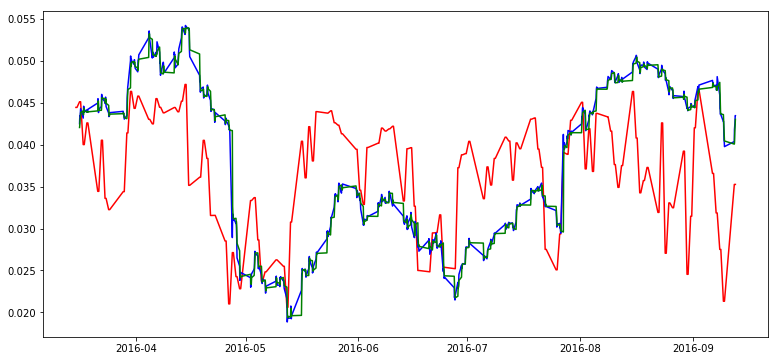

In [25]:
nn = 1000

plt.figure(figsize = (13, 6))


plt.plot(dataframe_merge['Time'][3:][-nn:], sent_dataset[3:][-nn:]/20, color='red')

plt.plot(dataframe['Time'][3:][-nn:], np.append(y_train, y_test)[-nn:], '-', ms=5, color='blue')

plt.plot(dataframe['Time'][3:][n:][-nn:], y_test_pred[-nn:],'-', ms=5, color='green')

plt.show()